In [166]:
import pandas as pd
import time
import torch
from torch import nn
from collections import defaultdict
from matplotlib import pyplot as plt

from transformers import BertTokenizer

In [4]:
# First download the dataset from https://www.kaggle.com/datasets/asaniczka/product-titles-text-classification
TITLES_TO_CATEGORIES_CSV = './titles_to_categories.csv'

In [118]:
df = pd.read_csv(TITLES_TO_CATEGORIES_CSV)

In [119]:
df.head()

,title,category_name
0,"Green Leaf WW3D Wonder Extension Cord Winder, ...",Industrial Scientific
1,8pcs Toilet Seat Bumpers Universal Toilet Repl...,Industrial Scientific
2,YaeCCC 19 Pcs Hole Saw Kit 3/4''(19mm)- 6''(15...,Industrial Scientific
3,LLPT Butyl Putty Tape White 1 Inch x 33Ft Tigh...,Industrial Scientific
4,"Lightbeam 16"" Long Stem Deep Fry Thermometer w...",Industrial Scientific


In [120]:
# Debugging
df = df.sample(frac=0.1).reset_index(drop=True)

In [121]:
len(df)

538990

In [122]:
df['category_name'].value_counts()[:100]

Sports & Outdoors                       71999
Baby                                     3696
Men's Shoes                              3242
Women's Handbags                         3019
Women's Shoes                            2940
                                        ...  
Hunting  Fishing                         1006
Snow  Ice Sports                         1005
Occupational Health  Safety Products     1004
Tattooing Supplies                       1001
RV Parts  Accessories                    1000
Name: category_name, Length: 100, dtype: int64

In [123]:
categories = df['category_name'].unique()
print(f'Number of categories: {len(categories)}')
categories

Number of categories: 726


array(["Girls' Clothing", 'Sports & Outdoors', 'Computers & Tablets',
       'Computer Audio  Video Accessories', 'Mobile Phones & Smartphones',
       'Welding & Soldering', 'Baby  Child Care Products',
       '3D Printing  Scanning', "Women's Accessories",
       'Handmade Home Décor', 'Automotive Tires & Wheels',
       'Diet  Nutrition Products', 'Tricycles, Scooters & Wagons',
       'Computer Audio & Video Accessories', "Men's Accessories",
       'Toy Vehicles', 'Computers', 'Cables & Accessories',
       'Kites  Wind Spinners', 'Camping  Hiking Equipment',
       'Power Transmission Products', 'Boys',
       'School & Educational Supplies', 'Karaoke Equipment',
       'Hallway Furniture', 'Indoor Lighting', 'Kitchen Cookware',
       'Laptop Bags', 'Baby Strollers & Accessories',
       'Nail Polish  Nail Decoration Products', 'Health  Personal Care',
       'Tablet Replacement Parts', 'Scanners & Accessories',
       'Baby Care Products', 'Pet Supplies', 'CD, Disc & Tape Playe

In [18]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [19]:
tokenizer.tokenize("I have a new GPU!")

['i', 'have', 'a', 'new', 'gp', '##u', '!']

In [124]:
df["tokenized_title"] = df["title"].apply(lambda title: tokenizer.tokenize(title))

In [125]:
df["category_label"] = df["category_name"].apply(lambda category: categories.tolist().index(category))

In [126]:
df[df["category_name"] == "Game Hardware"].head()

,title,category_name,tokenized_title,category_label
1530,Mouse Skatez/Mice Feet for for ROCCAT Kone AIM...,Game Hardware,"[mouse, skate, ##z, /, mice, feet, for, for, r...",468
1667,"3 in 1 Out HD Multimedia Interface Splitter, B...",Game Hardware,"[3, in, 1, out, hd, multimedia, interface, spl...",468
2588,"Glorious Fox Switches Forge, 120 Stück, Geschm...",Game Hardware,"[glorious, fox, switches, forge, ,, 120, stuck...",468
2692,"64 Bit USB Handbrake, PC Racing Game USB Handb...",Game Hardware,"[64, bit, usb, hand, ##bra, ##ke, ,, pc, racin...",468
3344,Dual Charging Dock Station for PS3 Move Contro...,Game Hardware,"[dual, charging, dock, station, for, ps, ##3, ...",468


In [127]:
# split the dataset into train and test
train_df = df.sample(frac=0.8, random_state=42)
test_df = df.drop(train_df.index)

In [128]:
vocab_counts = defaultdict(lambda: 0)
for tokenized_title in df["tokenized_title"]:
    for token in tokenized_title:
        vocab_counts[token] += 1

In [129]:
tokens_by_count = sorted([(v, i) for v, i in vocab_counts.items()], key=lambda x: x[1], reverse=True)
tokens_by_count = [('[PAD]', 0)] + tokens_by_count  # 0 is reserved for padding
vocab = {token: i for i, (token, _) in enumerate(tokens_by_count)}

In [131]:
len(vocab)

23479

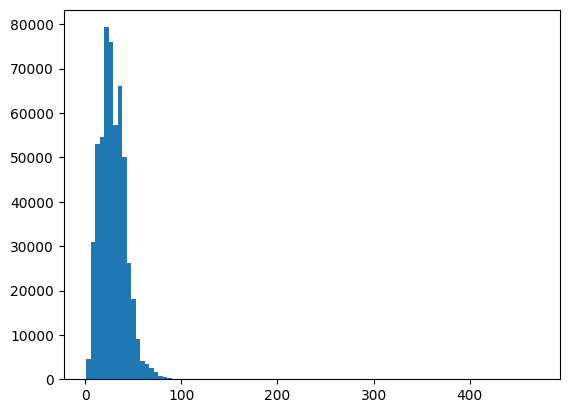

In [132]:
plt.hist([len(tokenized_title) for tokenized_title in df["tokenized_title"]], bins=100)
plt.show()

In [133]:
max_title_token_length = 50

In [134]:
def get_input_tensor(df, seq_len, vocab):
    df = df.reset_index(drop=True)
    data_tensor = torch.zeros((len(df), seq_len), dtype=torch.long)
    for i, row in df.iterrows():
        title = row["tokenized_title"]
        title = title[:seq_len]
        padded_title = title + ["[PAD]"] * (seq_len - len(title))
        for j, token in enumerate(padded_title):
            data_tensor[i][j] = vocab[token]
    return data_tensor


def get_label_tensor(df):
    return torch.tensor(df["category_label"].tolist())

train_input_tensor = get_input_tensor(train_df, max_title_token_length, vocab)
train_label_tensor = get_label_tensor(train_df)
test_input_tensor = get_input_tensor(test_df, max_title_token_length, vocab)
test_label_tensor = get_label_tensor(test_df)

In [176]:
class MLPModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dims, seq_length, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        hidden_layers = []
        for fan_in_dim, fan_out_dim in zip([embed_dim * seq_length] + hidden_dims[:-1], hidden_dims):
            hidden_layers.extend([
                nn.Linear(fan_in_dim, fan_out_dim),
                nn.ReLU(),
            ])
        self.hidden_layers = nn.ModuleList(hidden_layers)
        fc_fan_in_dim = hidden_dims[-1] if hidden_dims else embed_dim
        self.fc = nn.Linear(fc_fan_in_dim, num_classes)

    def forward(self, x):
        # print(f"input shape={x.shape}")
        x = self.embedding(x)
        # print(f"embedding shape={x.shape}")
        x = torch.reshape(x, x.shape[:-2] + (-1,))
        # print(f"concated shape={x.shape}")
        for hidden_layer in self.hidden_layers:
            x = hidden_layer(x)
        # print(f"last layer shape={x.shape}")
        x = self.fc(x)
        # print(f"output shape={x.shape}")
        return x
    

mlp_e32_512 = MLPModel(
    vocab_size=len(vocab),
    embed_dim=32,
    hidden_dims=[512],
    seq_length=max_title_token_length,
    num_classes=len(categories),
)

optimizer_mlp_e32_512 = torch.optim.Adam(mlp_e32_512.parameters(), lr=0.001)
mlp_e32_512

MLPModel(
  (embedding): Embedding(23479, 32)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=1600, out_features=512, bias=True)
    (1): ReLU()
  )
  (fc): Linear(in_features=512, out_features=726, bias=True)
)

In [175]:
def train(model, input_tensor, label_tensor, optimizer, epochs=1, batch_size=256):
    loss_fn = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        model.train()
        start_time = time.time()
        for i in range(0, input_tensor.shape[0], batch_size):
            batch_input_tensor = input_tensor[i:i+batch_size]
            # print(f"batch_input_tensor.shape={batch_input_tensor.shape}")
            batch_label_tensor = label_tensor[i:i+batch_size]
            # print(f"batch_label_tensor.shape={batch_label_tensor.shape}")
            optimizer.zero_grad()
            output = model(batch_input_tensor)
            # print(f"output.shape={output.shape}")
            loss = loss_fn(output, batch_label_tensor).mean()
            # print(f"loss.shape={loss.shape}")
            loss.backward()
            optimizer.step()
            # break
            if i / batch_size % 100 == 0:
                print(f"Epoch {epoch} step {i / batch_size} loss: {loss.item()}")
        end_time = time.time()
        print(f"Epoch {epoch} loss: {loss.item()}  time: {(end_time - start_time):.2f}s")
        # break
    return


def eval(model, input_tensor, label_tensor):
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        pred = output.argmax(dim=1, keepdim=True)
        correct = pred.eq(label_tensor.view_as(pred)).type(torch.float).mean()
    print(f"Accuracy: {correct.item() * 100:.2f}%")

In [187]:
train(mlp_e32_512, train_input_tensor, train_label_tensor, optimizer_mlp_e32_512, batch_size=1024)

Epoch 0 step 0.0 loss: 1.2104296684265137
Epoch 0 step 100.0 loss: 1.1475733518600464
Epoch 0 step 200.0 loss: 0.9817432165145874
Epoch 0 step 300.0 loss: 0.9604343771934509
Epoch 0 step 400.0 loss: 0.9006027579307556
Epoch 0 loss: 0.32116779685020447  time: 6.51s


In [188]:
print("Evaluating on train set:")
eval(mlp_e32_512, train_input_tensor, train_label_tensor)

print()
print("Evaluating on test set:")
eval(mlp_e32_512, test_input_tensor, test_label_tensor)

Evaluating on train set:
Accuracy: 78.29%

Evaluating on test set:
Accuracy: 44.31%


In [199]:
sum([p.numel() for p in mlp_e32_512.parameters()])

1943478